# Analysis on 2D Heisenberg model

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

# import heisenberg_2d
from heisenberg_2d import initialize, metropolis, energy, magnetization

In [2]:
# Settings
snaps = []
n_temp = 100

N = 15
H = 1
steps = 100
temp = np.linspace(1.5,3.5,n_temp)


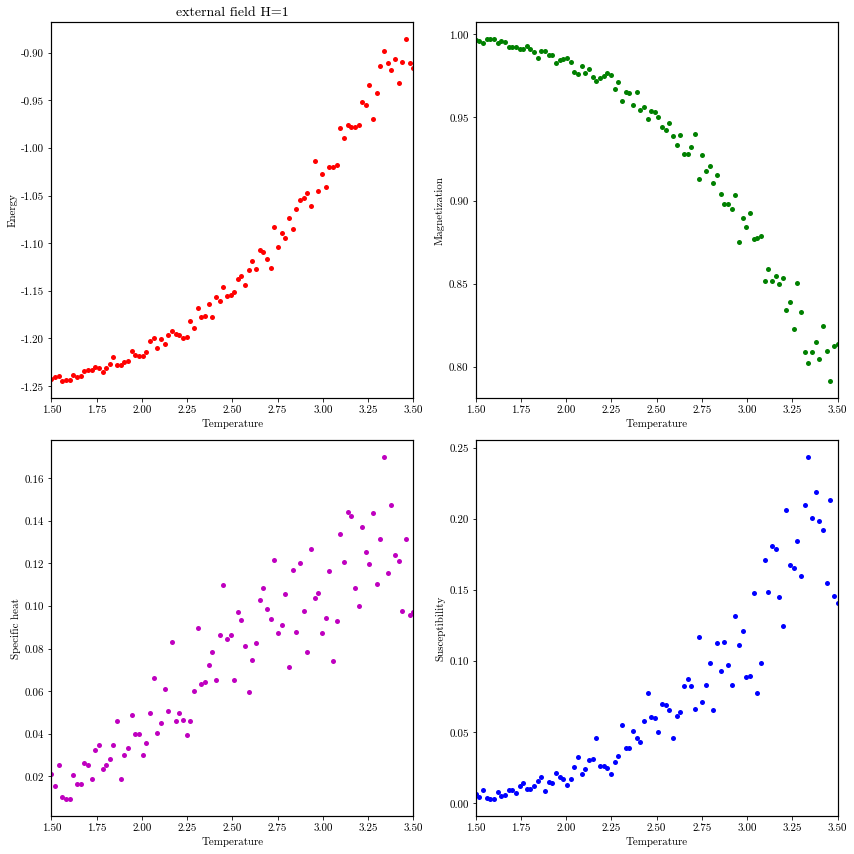

In [3]:
## small sanity check on input parameters
if N<2 or steps<1 or temp[0]<0:
    print("Invalid command line parameters")

## Energy and other parameters we want to compute
E = np.zeros(len(temp))
M = np.zeros(len(temp))
C = np.zeros(len(temp))
X = np.zeros(len(temp))

## parameters to calculate running average (notice that these are averages per spin)
n1 = 1.0/(steps*N*N)
n2 = 1.0/(steps*steps*N*N)

for ii, T in enumerate(temp):
    E1=0
    M1=0
    E2=0
    M2=0
    grid = initialize(N) ## get the initial configuration
    beta = 1.0/T ## k_B = 1  


    ## first we equilibrate the system 
    ## (assumption is that snapshots are wanted here)
    for t in range(steps):
        if t in snaps:
            plot_system(grid, t, T, H)	

        metropolis(grid, beta, H)	

    ## then we start to actually collect data, if we aren't just plotting snapshots
    if len(snaps)==0:
        for t in range(steps):
            metropolis(grid, beta, H)	
            tE = energy(grid, H)
            tM = magnetization(grid)

            E1 += tE	
            E2 += tE*tE
            M1 += tM			
            M2 += tM*tM

        E[ii] = n1*E1	
        M[ii] = n1*M1
        C[ii] = beta*beta*(n1*E2 - n2*E1*E1)
        X[ii] = beta*(n1*M2 - n2*M1*M1)

## then we plot a figure with energy, magnetization, specific heat and susceptibility
if len(snaps)==0:
    plt.figure(figsize=(12,12))

    plt.subplot(2,2,1)
    plt.title('external field H={}'.format(H))
    plt.plot(temp, E, 'ro', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Energy')

    plt.subplot(2,2,2)
    plt.plot(temp, M, 'go', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Magnetization')

    plt.subplot(2,2,3)
    plt.plot(temp, C, 'mo', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Specific heat')

    plt.subplot(2,2,4)
    plt.plot(temp, X, 'bo', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Susceptibility')


    plt.tight_layout()
    ## uncomment if you want to save the data
    #np.savetxt("ising_2d_{}_{}_{}.dat".format(N,steps,H), np.array([temp, E, M , C,X]).transpose())

plt.show()



